In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def convert_to_npz (filename_csv, short_name_npz):
    data = np.genfromtxt(filename_csv, delimiter=',')[:,4]
    np.savez(short_name_npz, data=data)  # Save data with key 'data' in npz file

    
def load_from_npz(short_name_npz):
    loaded_data = np.load(short_name_npz)
    return loaded_data['data']
    

In [7]:
convert = True

if convert:
    convert_to_npz("data/240611/25mhz_240611_153549.csv", "undrifted.npz")
loaded_data = load_from_npz("undrifted.npz")
    

In [21]:
def comb_plot(data,spacing=100e3, d_Hz=1000):
    Ns = len(data)
    sampling_rate = 250e6
    dt = Ns/sampling_rate
    df = 1/dt

    ndx = 50e3/df
    d_ndx = spacing/df
    coef = np.fft.rfft(data)
    freqs = np.fft.rfftfreq(Ns)
    pwr = np.abs(coef[int(ndx):int(60e6/df):int(d_ndx)]**2)
    avgd = []
    i = 0.05e6/df
    d = d_Hz/df
    while i <= 60e6/df:
        avgd.append(np.sum(np.abs(coef[int(i-d):int(i+d)]**2)))
        i += d_ndx
        
    return np.array(pwr),freqs,np.array(avgd)

In [33]:
pwrs,freqs,avgs = comb_plot(loaded_data,100e3)
pwrs,freqs,avgs2 = comb_plot(loaded_data,100e3, d_Hz=500)
pwrs,freqs,avgs3 = comb_plot(loaded_data,100e3, d_Hz=2000)

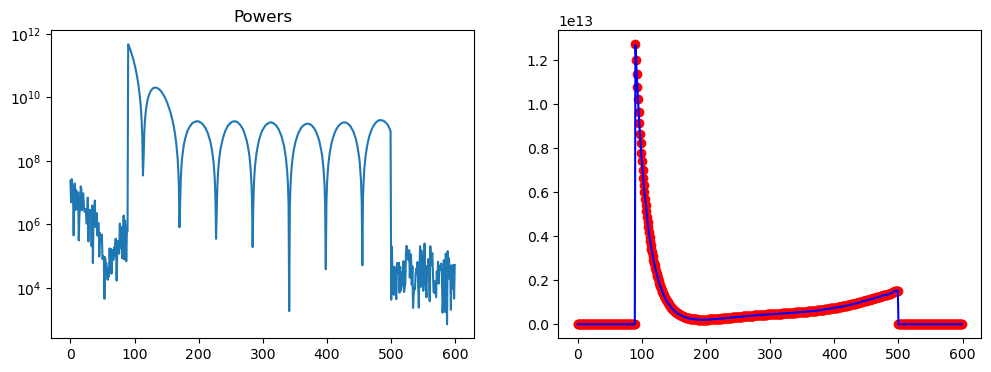

In [50]:
fig = plt.figure(figsize=(12, 4)) 
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(pwrs)
ax1.title.set_text('Powers')
ax1.semilogy()
ax2.plot(avgs, 'ro')
ax2.plot(avgs2, 'b-')

# Set the y-axis of ax2 to a logarithmic scale
#ax2.set_yscale('log')


plt.show()
#ax2.set_xlim(86,100)
ax2.title.set_text('Averages')

(0.98, 1.02)

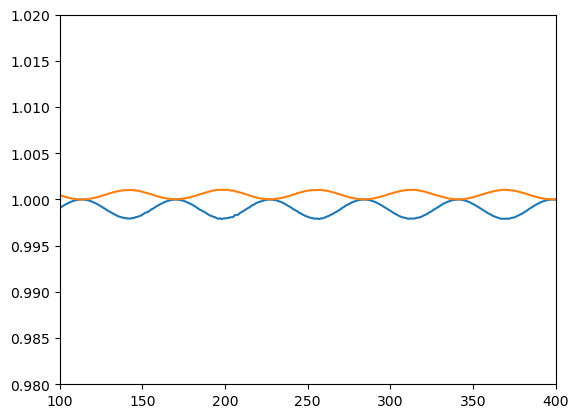

In [43]:
plt.plot(avgs2/avgs)
plt.plot(avgs3/avgs)
plt.xlim(100,400)
plt.ylim(0.98,1.02)

In [49]:
#First normalize and then save
precomp = avgs / avgs.sum()
np.savez("precompensation.npz", precomp=precomp[:512])

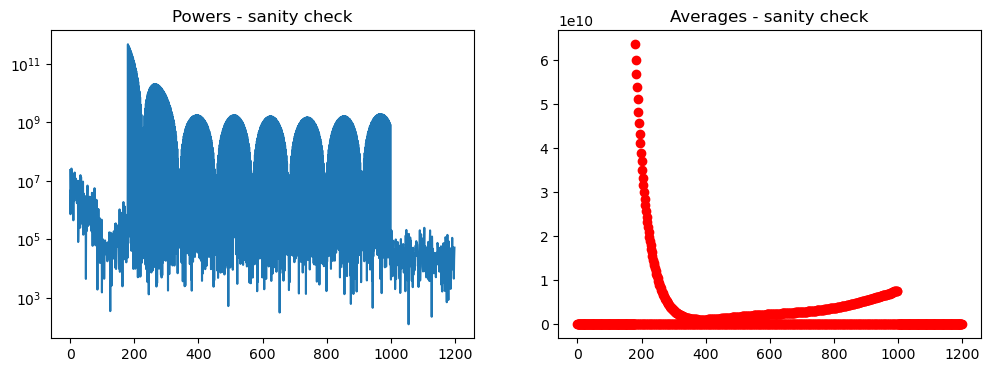

In [11]:
fig = plt.figure(figsize=(12, 4)) 
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(pwr_check)
ax1.title.set_text('Powers - sanity check')
ax1.semilogy()
ax2.plot(avg_check, 'ro')
ax2.title.set_text('Averages - sanity check')

(-10000000000.0, 10000000000.0)

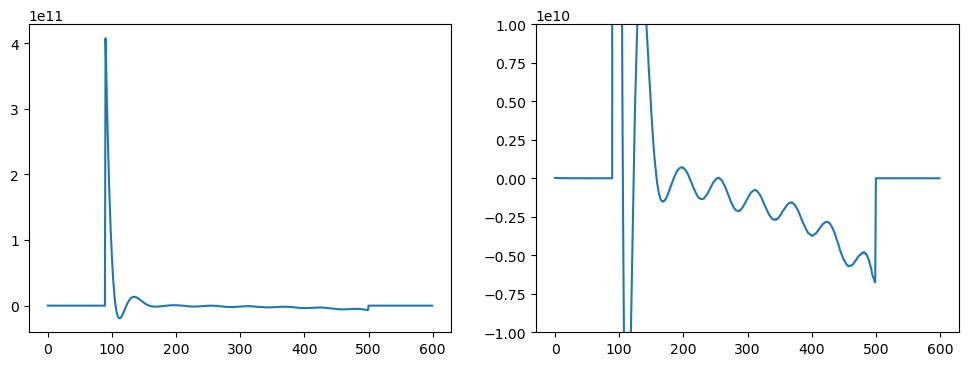

In [12]:
# look at the noise
noise = pwrs - avgs

fig = plt.figure(figsize=(12, 4)) 
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(noise)
ax2.plot(noise)
ax2.set_ylim(-1e10,1e10)


In [19]:
#wrong, revisit maybe
comb = np.zeros(len(pwrs))
indices = []
for i in range(len(pwrs)):
    didx = 50
    if i+1 == len(pwrs):
        break
        
    if pwrs[i] > 1e11:
        comb[i] = pwrs[i]
        indices.append(i)
        if comb[i-1] != 0:
            peak_idx = np.argmax(pwrs[i-didx:i+didx])
            comb[peak_idx] = pwrs[peak_idx]
            comb[peak_idx - didx:peak_idx] = 0
            comb[peak_idx + 1:peak_idx + didx] = 0
        i += didx
    

comb = np.array(comb)